In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from read_and_clean_data import (
    download_gios_archive, 
    download_metadata, 
    clean_data,
    get_common_stations,
    save_cleaned_data
)

from data_analysis import (
    load_data,
    calculate_daily_stats,
    calculate_monthly_stats,
    merge_stats,
    save_to_csv
)

from visualizations import (
    plot_monthly_trends,
    heatmaps,
    days_over_norm
)

Pobieranie i czyszczenie danych

In [2]:
# URL-e do pobierania danych
GIOS_ARCHIVE_URL = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/"
METADATA_URL = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/622"

# Słownik konfiguracyjny
YEAR_CONFIG = {
    2015: {
        'archive_id': '236',
        'pm25_filename': '2015_PM25_1g.xlsx'
    },
    2018: {
        'archive_id': '603',
        'pm25_filename': '2018_PM25_1g.xlsx'
    },
    2021: {
        'archive_id': '486',
        'pm25_filename': '2021_PM25_1g.xlsx'
    },
    2024: {
        'archive_id': '582',
        'pm25_filename': '2024_PM25_1g.xlsx'
    }
}

In [3]:
def download_and_clean(years_to_process=None):
    """Główna funkcja wykonująca cały proces pobierania i czyszczenia danych."""
    print("=== Rozpoczynanie procesu pobierania i czyszczenia danych PM2.5 ===")
    
    # Jeśli nie podano lat, użyj wszystkich z konfiguracji
    if years_to_process is None:
        years_to_process = list(YEAR_CONFIG.keys())
    
    # Pobieranie metadanych
    df_metadata = download_metadata(METADATA_URL)
    if df_metadata is None:
        print("Nie udało się pobrać metadanych.")
        return None
    
    # Pobieranie i czyszczenie danych dla każdego roku
    print(f"\nPrzetwarzanie lat: {years_to_process}")
    cleaned_data_dict = {}
    
    for year in years_to_process:
        if year not in YEAR_CONFIG:
            print(f"Ostrzeżenie: Brak konfiguracji dla roku {year}.")
            continue
        
        print(f"\nPrzetwarzanie roku {year}")
        
        # Pobierz dane
        df_raw = download_gios_archive(year, YEAR_CONFIG[year], GIOS_ARCHIVE_URL)
        if df_raw is None:
            print(f"Nie udało się pobrać danych dla roku {year}.")
            continue
        
        # Oczyść dane
        try:
            df_clean = clean_data(df_raw, year, df_metadata)
            cleaned_data_dict[year] = df_clean
        except Exception as e:
            print(f"Błąd podczas czyszczenia danych dla roku {year}: {e}")
            continue
    
    # Sprawdź czy mamy dane do połączenia
    if not cleaned_data_dict:
        print("Brak danych do połączenia. Kończenie pracy.")
        return None
    
    # Znajdź wspólne stacje
    common_stations = get_common_stations(cleaned_data_dict)
    
    # Połącz dane z wszystkich lat
    all_data_frames = list(cleaned_data_dict.values())
    df_all = pd.concat(all_data_frames, ignore_index=True)
    
    # Filtruj tylko wspólne stacje
    if common_stations:
        initial_count = len(df_all)
        df_all = df_all[df_all['kod_stacji'].isin(common_stations)]
        filtered_count = initial_count - len(df_all)
        print(f"Usunięto {filtered_count} pomiarów z nie-wspólnych stacji")
    
    # Zapis do pliku
    output_file = save_cleaned_data(df_all)
    
    # Podsumowanie
    print("\n=== PODSUMOWANIE ===")
    print(f"Przetworzone lata: {list(cleaned_data_dict.keys())}")
    print(f"Liczba wspólnych stacji: {len(common_stations)}")
    print(f"Całkowita liczba pomiarów: {df_all.shape[0]}")
    print(f"Zakres dat: {df_all['data'].min().date()} - {df_all['data'].max().date()}")
    print(f"Plik wynikowy: {output_file}")
    
    # Przykładowe dane
    print("\nPrzykładowe dane:")
    print(df_all.head())
    
    return df_all

In [4]:
# Uruchomienie głównej funkcji
cleaned_df = download_and_clean(years_to_process=[2015, 2018, 2021, 2024])

=== Rozpoczynanie procesu pobierania i czyszczenia danych PM2.5 ===
Metadane pobrane pomyślnie: 1134 wierszy, 15 kolumn

Przetwarzanie lat: [2015, 2018, 2021, 2024]

Przetwarzanie roku 2015
Dane dla roku 2015 pobrane pomyślnie
Po filtracji: 8761 wierszy (usunięto 2)
Rok 2015: Utworzono mapowanie dla 302 starych kodów stacji
367920 pomiarów, 365 dni, 42 stacji

Przetwarzanie roku 2018
Dane dla roku 2018 pobrane pomyślnie
Po filtracji: 8762 wierszy (usunięto 4)
Rok 2018: Utworzono mapowanie dla 302 starych kodów stacji
446760 pomiarów, 365 dni, 51 stacji

Przetwarzanie roku 2021
Dane dla roku 2021 pobrane pomyślnie
Po filtracji: 8761 wierszy (usunięto 5)
Rok 2021: Utworzono mapowanie dla 302 starych kodów stacji
770880 pomiarów, 365 dni, 88 stacji

Przetwarzanie roku 2024
Dane dla roku 2024 pobrane pomyślnie
Po filtracji: 8785 wierszy (usunięto 5)
Rok 2024: Utworzono mapowanie dla 302 starych kodów stacji
Ostrzeżenie rok 2024: Brak miejscowości dla 1 stacji ['LuLubsStrzelMOB']
843264 pom

Liczenie średnich i wskazywanie dni z przekroczeniem normy

In [5]:
def calculate_statistics():
    """Oblicza statystyki dobowe i miesięczne oraz łączy je z danymi."""
    df = load_data('pm25_cleaned.csv')

    daily = calculate_daily_stats(df)
    monthly = calculate_monthly_stats(df)

    df_updated = merge_stats(df, daily, monthly)

    save_to_csv(df_updated)

    print("Statystyki zostały obliczone i zapisane")
    print(f"Dodano {len(df_updated.columns) - len(df.columns)} kolumny z nowymi statystykami")
    
    return df_updated

In [6]:
# Uruchomienie funkcji obliczającej statystyki
df_with_stats = calculate_statistics()

Statystyki zostały obliczone i zapisane
Dodano 3 kolumny z nowymi statystykami


Wizualizacje

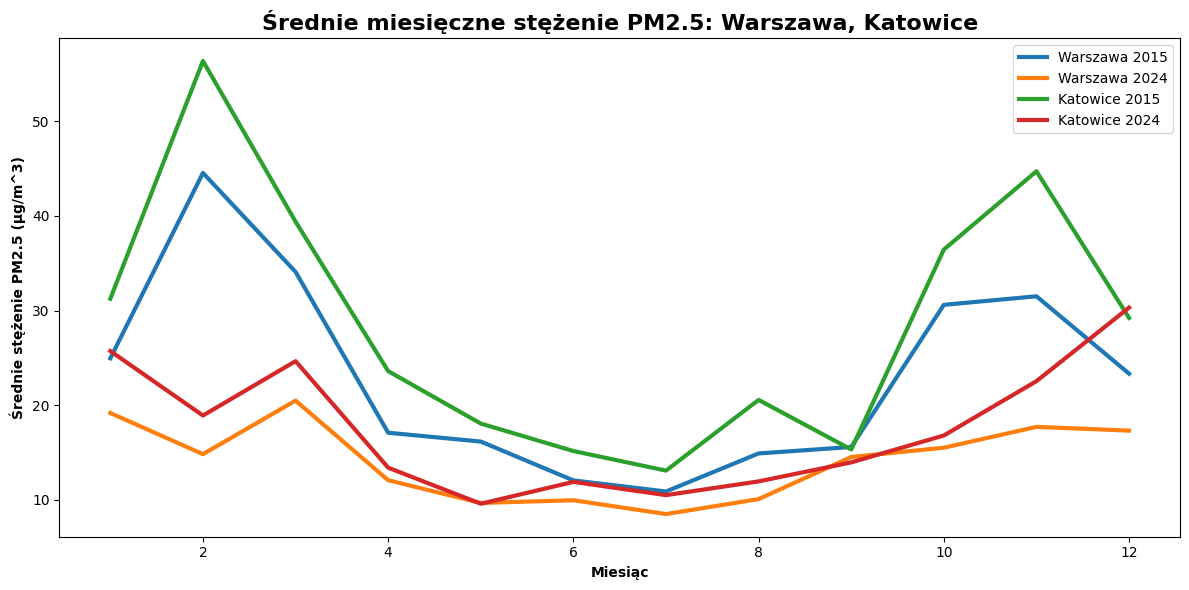

In [7]:
# Wykres trendów miesięcznych dla wybranych miast i lat
plot_monthly_trends(df_with_stats)

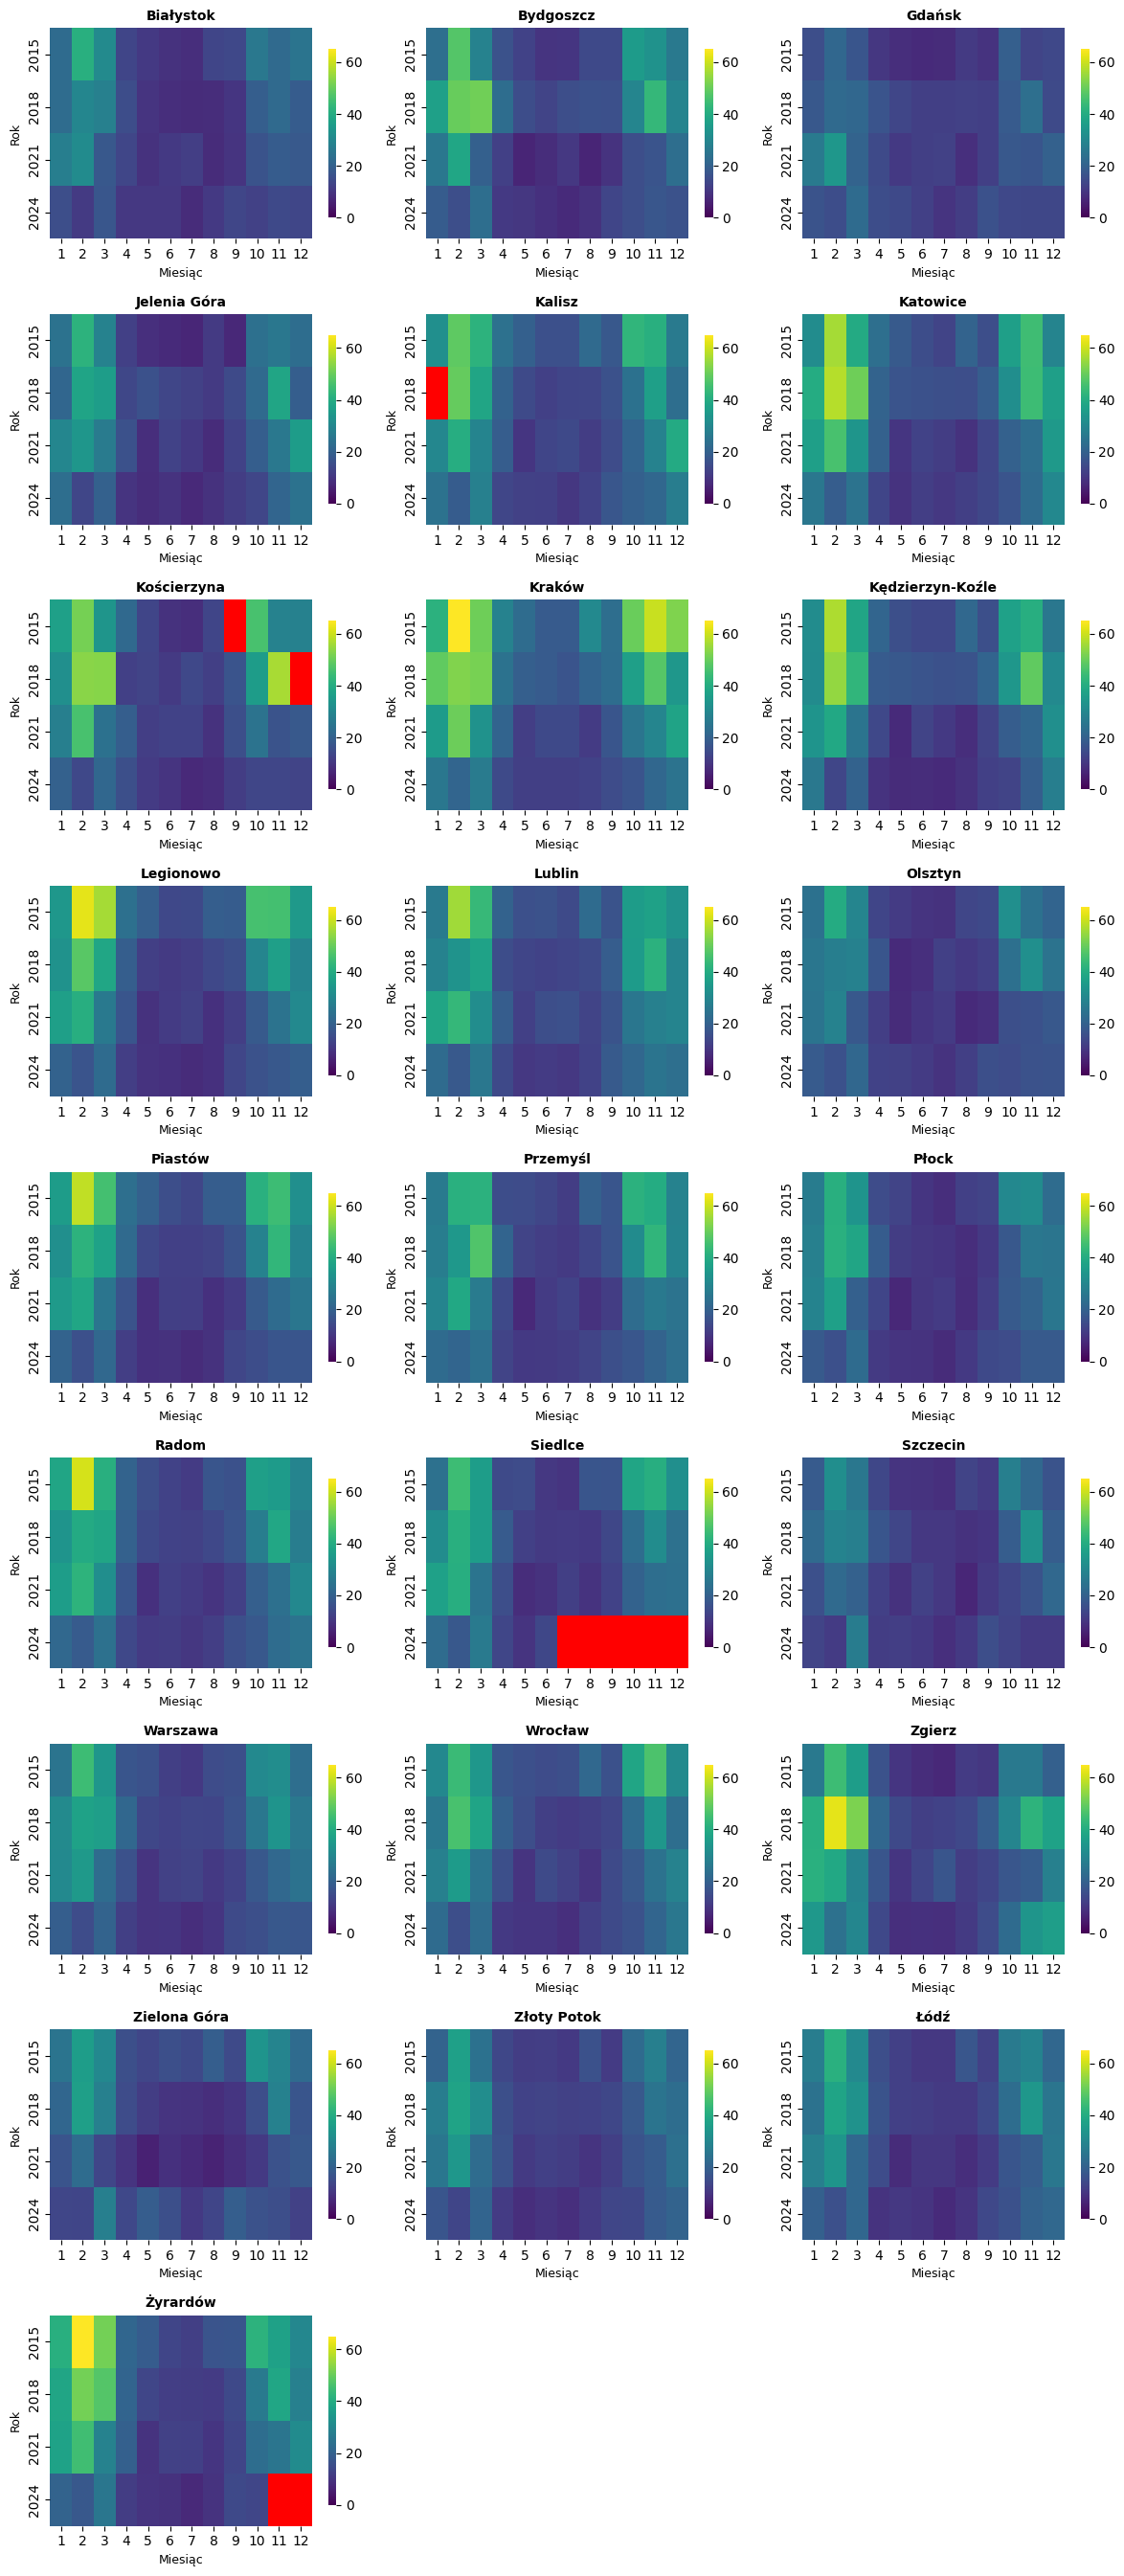

In [8]:
# Heatmapy średnich miesięcznych dla wybranych miast i lat
heatmaps(df_with_stats)

Top 3 stacje z największą liczbą dni powyżej normy (2024):
      kod_stacji Miejscowość   rok  dni_powyzej_normy
31  LdZgieMielcz      Zgierz  2024               4536
39  MpKrakAlKras      Kraków  2024               4272
23  LbLubObywate      Lublin  2024               4080

Bottom 3 stacje z najmniejszą liczbą dni powyżej normy (2024):
       kod_stacji Miejscowość   rok  dni_powyzej_normy
115  ZpSzczAndrze    Szczecin  2024               1728
83   PdBialUpalna   Białystok  2024               1824
63   MzSiedKonars     Siedlce  2024               1896


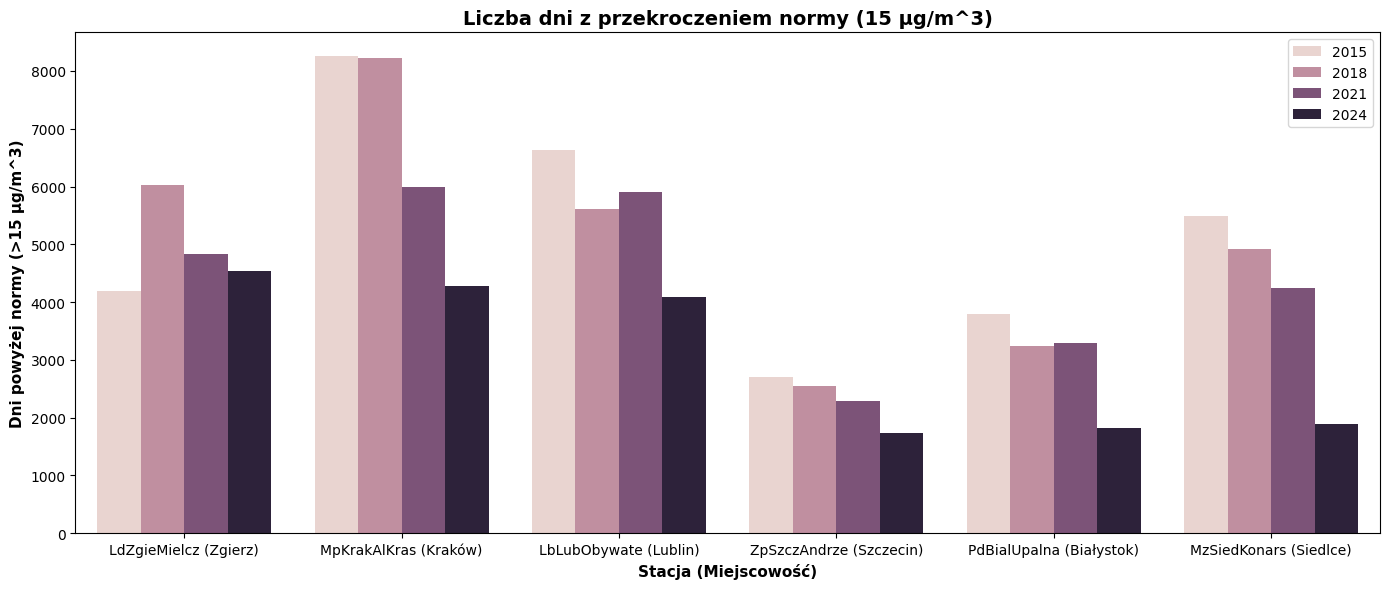

In [9]:
# Wykres słupkowy dni z przekroczeniem normy PM2.5
days_over_norm(df_with_stats)